In [6]:

import numpy as np
import matplotlib.pyplot as plt
import torch as T
import pickle
device = T.device("cuda:0")  # apply to Tensor or Module



In [7]:
from os import listdir
from os.path import isfile, join
import glob
path = "/mnt/d/Work/Dissertation/Preprocessing/VNIR-Field1/"
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) ]
import torch


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/mnt/d/Work/Dissertation/Preprocessing/VNIR-Field1/'

In [3]:
import struct
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

In [4]:
tensordata=[]
imgdata=[]
for n in range(0,len(onlyfiles)):
    with open("/mnt/d/Work/Dissertation/Preprocessing/VNIR-Field1/F01 ("+str(n)+")", "rb") as f:
        img = np.zeros((270,200,200))
        simg = np.zeros((270,164,164))
        for c in range(270):
            for i in range(200):
                for j in range(200):
                    pix = f.read(8)
                    if pix:
                        # Do stuff with byte.
                        val = struct.unpack('d',pix)
                        #print("img[{},{},{}] = {:.3f} {} ".format(c,i,j,val[0],img[c,i,j]), end = '')
                        img[c,i,j] = val[0]
                        
            im = Image.fromarray(img[c])
            
    
    imgdata.append(img)
big_images=np.array(imgdata)
crop_images=big_images[:,:,0:164,0:164]
del imgdata
del big_images
        

In [5]:
"""with open("periya_images.pickle","wb") as f:
    pickle.dump(crop_images,f)"""

with open("periya_images.pickle","rb") as f:
    crop_images=pickle.load(f)
crop_images.shape

(51, 270, 164, 164)

In [5]:
crop_images = torch.tensor(crop_images,dtype=T.float32)
crop_images.to(device)

tensor([[[[0.0901, 0.0905, 0.0909,  ..., 0.0708, 0.0704, 0.0711],
          [0.1018, 0.0931, 0.0869,  ..., 0.0703, 0.0711, 0.0657],
          [0.0925, 0.0898, 0.0857,  ..., 0.0711, 0.0665, 0.0582],
          ...,
          [0.0639, 0.0603, 0.0551,  ..., 0.0586, 0.0780, 0.1233],
          [0.0630, 0.0481, 0.0684,  ..., 0.0786, 0.1079, 0.1404],
          [0.0623, 0.0571, 0.0522,  ..., 0.0702, 0.1402, 0.2073]],

         [[0.0966, 0.0971, 0.1000,  ..., 0.0726, 0.0717, 0.0763],
          [0.1085, 0.1008, 0.1035,  ..., 0.0714, 0.0763, 0.0812],
          [0.0949, 0.1021, 0.1045,  ..., 0.0763, 0.0804, 0.0879],
          ...,
          [0.0612, 0.0580, 0.0555,  ..., 0.0677, 0.0934, 0.1563],
          [0.0615, 0.0543, 0.0558,  ..., 0.0960, 0.1360, 0.1765],
          [0.0634, 0.0579, 0.0566,  ..., 0.0713, 0.1809, 0.2196]],

         [[0.0996, 0.0891, 0.1016,  ..., 0.0691, 0.0695, 0.0647],
          [0.1112, 0.0994, 0.1025,  ..., 0.0698, 0.0647, 0.0610],
          [0.0944, 0.0976, 0.1035,  ..., 0

In [6]:
T.cuda.memory_allocated()

668991488

In [7]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [8]:
# -----------------------------------------------------------

class UciDigitsDataset(T.utils.data.Dataset):
  def __init__(self, src_file, num_rows=None):
    # 0,5,12,13,16, . . (64 values),9(label/digit)
    # 1797 items
    tmp_x = np.loadtxt(src_file, max_rows=num_rows,
      usecols=range(0,64), delimiter=",", skiprows=0,
      dtype=np.float32)
    tmp_x /= 16

    tmp_y = np.loadtxt(src_file, max_rows=num_rows,
      usecols=64, delimiter=",", skiprows=0,
      dtype=np.int64)  # used for graph, not for training

    self.x_data = T.tensor(tmp_x, dtype=T.float32)
    self.y_data = T.tensor(tmp_y, dtype=T.int64) 

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    pixels = self.x_data[idx]
    digit = self.y_data[idx] 
    sample = { 'pixels' : pixels, 'digit' : digit }
    return sample



In [9]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enc1 = T.nn.Conv2d(270, 810, 7)  # 64-16-2-16-64
    self.enc2 = T.nn.Conv2d(810, 540 , 7)
    #self.pool = nn.MaxPool2d(2, 2), 7)
    
    self.dec1 = T.nn.ConvTranspose2d(540, 810, 7)
    self.dec2 = T.nn.ConvTranspose2d(810, 270, 7)
  
    T.nn.init.xavier_uniform_(self.enc1.weight)
    T.nn.init.zeros_(self.enc1.bias)
    T.nn.init.xavier_uniform_(self.enc2.weight)
    T.nn.init.zeros_(self.enc2.bias)
    T.nn.init.xavier_uniform_(self.dec1.weight)
    T.nn.init.zeros_(self.dec1.bias)
    T.nn.init.xavier_uniform_(self.dec2.weight)
    T.nn.init.zeros_(self.dec2.bias)

  def encode(self, x):
    
    z = T.relu(self.enc1(x))
    z = T.relu(self.enc2(z))
     # act depends on scenario
    return z.to(device)

  def decode(self, x):
    
    z = T.relu(self.dec1(x))
    z = self.dec2(z)  # no activation
    return z   

  def forward(self, x):
    
    z = self.encode(x)
    z = self.decode(z)
    return z



In [40]:

force_cudnn_initialization()

In [41]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

# 1. create DataLoader object
print("\nCreating UCI Digits Dataset ")

train_file = "digits_uci_test_1797.txt"
train_ds = UciDigitsDataset(train_file) # all 1797 rows
  

bat_size = 5
train_ldr = T.utils.data.DataLoader(crop_images,
batch_size=bat_size, shuffle=True)
train_ldr
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 30
ep_log_interval = 10
lrn_rate = 0.01

loss_func = T.nn.MSELoss()
loss_func = T.nn.L1Loss(reduction='sum')
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()
for epoch in range(0, max_epochs):
  epoch_loss = 0  # for one full epoch

  for (batch_idx, batch) in enumerate(train_ldr):
    X = batch.to(device)  # no targets needed

    optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt, X)  # note: X not Y
    epoch_loss += loss_obj.item()  # accumulate
    loss_obj.backward()
    optimizer.step()

  if epoch % ep_log_interval == 0:
    print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()






Begin UCI digits auto-reduce-viz demo job 

Creating UCI Digits Dataset 

Creating 64-16-2-16-63 autoencoder 

bat_size =   5 
loss = L1Loss()
optimizer = Adam
max_epochs =  30 
lrn_rate = 0.010 

Starting training


RuntimeError: CUDA out of memory. Tried to allocate 386.00 MiB (GPU 0; 8.00 GiB total capacity; 6.01 GiB already allocated; 0 bytes free; 7.06 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
#torch.save(net.state_dict(), 'hari_model_sample.pth')
torch.save(net, 'hari_model_struct.pth')

In [27]:
#net = torch.load('hari_model_struct.pth')
net=Net()
net.load_state_dict(torch.load('hari_model_sample.pth'))
net.to(device)

Net(
  (enc1): Conv2d(270, 810, kernel_size=(7, 7), stride=(1, 1))
  (enc2): Conv2d(810, 540, kernel_size=(7, 7), stride=(1, 1))
  (dec1): ConvTranspose2d(540, 810, kernel_size=(7, 7), stride=(1, 1))
  (dec2): ConvTranspose2d(810, 270, kernel_size=(7, 7), stride=(1, 1))
)

In [12]:
bat_size = 5
train_ldr = T.utils.data.DataLoader(crop_images,
batch_size=bat_size, shuffle=True)

In [13]:
for i in train_ldr:
    break

In [36]:
out=net(i.to(device))

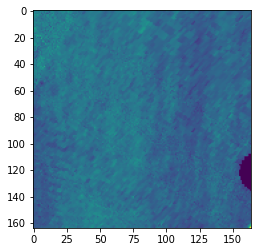

In [37]:
import matplotlib.pyplot as plt

plt.imshow(i[0][0])

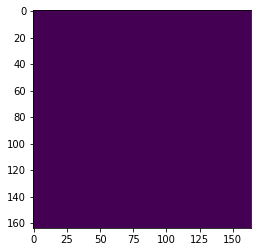

In [38]:
plt.imshow(out[0][2].to("cpu").detach().numpy())

In [24]:
loss_func(out[0][0].to("cpu"), i[0][0].to("cpu"))

tensor(0.0136, grad_fn=<MseLossBackward0>)

In [34]:
i[0][0]

tensor([[0.0901, 0.0905, 0.0909,  ..., 0.0708, 0.0704, 0.0711],
        [0.1018, 0.0931, 0.0869,  ..., 0.0703, 0.0711, 0.0657],
        [0.0925, 0.0898, 0.0857,  ..., 0.0711, 0.0665, 0.0582],
        ...,
        [0.0639, 0.0603, 0.0551,  ..., 0.0586, 0.0780, 0.1233],
        [0.0630, 0.0481, 0.0684,  ..., 0.0786, 0.1079, 0.1404],
        [0.0623, 0.0571, 0.0522,  ..., 0.0702, 0.1402, 0.2073]])

In [39]:
out[0][0]

tensor([[0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
        [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
        [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
        ...,
        [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
        [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
        [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [30]:
bow=crop_images.to(device)
xy = net.encode(bow).to(device)
xy = xy.to("cpu").detach().numpy()  

RuntimeError: CUDA out of memory. Tried to allocate 1.73 GiB (GPU 0; 8.00 GiB total capacity; 4.72 GiB already allocated; 0 bytes free; 6.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
  with T.no_grad():
    bow=train_ds[:]['pixels']
    bow=crop_images.to(device)
    xy = net.encode(bow)  # (1797,2)
  lbls = train_ds[:]['digit']  # (1797,)
  lbls=lbls.to(device)
  xy = xy.to("cpu").detach().numpy()      # tensors to numpy arrays
  lbls = lbls.to("cpu").detach().numpy()
  
  

  fig, ax = plt.subplots()
  colors = ['red', 'blue', 'green', 'yellow', 'orange',
            'black', 'brown', 'purple', 'silver', 'pink']
  digits = [' 0 ', ' 1 ', ' 2 ', ' 3 ', ' 4 ',
            ' 5 ', ' 6 ', ' 7 ', ' 8 ', ' 9 ']

  # process by each color/class
  for i in range(len(colors)):  # 0 to 9 each color
    color = colors[i]
    rows = []                   # select rows for curr color
    for j in range(len(xy)):    # 0 to 1796
      if lbls[j] == i:
        rows.append(True)       # to extract rows, must use bool
      else:
        rows.append(False)

    rows = np.array(rows, dtype=np.bool)  # list to array
    selected = xy[rows,:]                 # like (178,2)

    x = selected[:,0]  # like (178,)
    y = selected[:,1]
    scatter  = ax.scatter(x, y, c=color, s=20, alpha=0.9)
    # and continue on to next color/class

  txt = "\n" + "0=red \n" + "1=blue \n" + "2=green \n" + \
    "3=yellow \n" + "4=orange \n" + "5=black \n" + \
    "6=brown \n" + "7=purple \n" + "8=silver \n" + "9=pink \n"

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
  ax.text(0.95, 0.95, txt, transform=ax.transAxes, fontsize=8,
    verticalalignment='top', bbox=props)
  ax.grid(True)
  plt.xlabel('component 1')
  plt.ylabel('component 2')
  plt.show()

  print("\nEnd UCI digits auto-reduce-viz demo")


main()

NameError: name 'train_ds' is not defined

In [ ]:
bow

In [ ]:
train_ds

In [ ]:
train_file = "digits_uci_test_1797.txt"
train_ds = UciDigitsDataset(train_file)

In [ ]:
main.lbls

AttributeError: 'function' object has no attribute 'lbls'


Begin UCI digits auto-reduce-viz demo job 

Creating UCI Digits Dataset 

Creating 64-16-2-16-63 autoencoder 

bat_size =  10 
loss = MSELoss()
optimizer = Adam
max_epochs = 200 
lrn_rate = 0.010 

Starting training
epoch =    0   loss = 12.8925
epoch =   10   loss = 9.6286
epoch =   20   loss = 9.5646
epoch =   30   loss = 9.5787
epoch =   40   loss = 9.5534
epoch =   50   loss = 9.5522
epoch =   60   loss = 9.5734
epoch =   70   loss = 9.5510
epoch =   80   loss = 9.5390
epoch =   90   loss = 9.5537
epoch =  100   loss = 9.5416
epoch =  110   loss = 9.5543
epoch =  120   loss = 9.5289
epoch =  130   loss = 9.5342
epoch =  140   loss = 9.5596
epoch =  150   loss = 9.5455
epoch =  160   loss = 9.5462
epoch =  170   loss = 9.5367
epoch =  180   loss = 9.5306
epoch =  190   loss = 9.5236
Done 

Creating graph from encoded data 


C:\Users\naras\AppData\Local\Temp\ipykernel_22272\3634218673.py:88: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rows = np.array(rows, dtype=np.bool)  # list to array


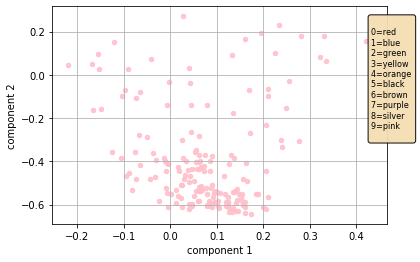


End UCI digits auto-reduce-viz demo


In [ ]:
# -----------------------------------------------------------


# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

# 1. create DataLoader object
print("\nCreating UCI Digits Dataset ")

train_file = "digits_uci_test_1797.txt"
train_ds = UciDigitsDataset(train_file) # all 1797 rows


bat_size = 10
train_ldr = T.utils.data.DataLoader(train_ds,
batch_size=bat_size, shuffle=True)

# 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 200
ep_log_interval = 10
lrn_rate = 0.01

loss_func = T.nn.MSELoss()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()
for epoch in range(0, max_epochs):
    epoch_loss = 0  # for one full epoch

    for (batch_idx, batch) in enumerate(train_ldr):
        X = batch['pixels'].to(device)  # no targets needed

        optimizer.zero_grad()
        oupt = net(X)
        loss_obj = loss_func(oupt, X)  # note: X not Y
        epoch_loss += loss_obj.item()  # accumulate
        loss_obj.backward()
        optimizer.step()

    if epoch % ep_log_interval == 0:
        print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()

with T.no_grad():
    bow=train_ds[:]['pixels']
    bow=bow.to(device)
    xy = net.encode(bow)  # (1797,2)
    lbls = train_ds[:]['digit']  # (1797,)
    lbls=lbls.to(device)
    xy = xy.to("cpu").detach().numpy()      # tensors to numpy arrays
    lbls = lbls.to("cpu").detach().numpy()



fig, ax = plt.subplots()
colors = ['red', 'blue', 'green', 'yellow', 'orange',
        'black', 'brown', 'purple', 'silver', 'pink']
digits = [' 0 ', ' 1 ', ' 2 ', ' 3 ', ' 4 ',
        ' 5 ', ' 6 ', ' 7 ', ' 8 ', ' 9 ']

# process by each color/class
for i in range(len(colors)):  # 0 to 9 each color
    color = colors[i]
rows = []                   # select rows for curr color
for j in range(len(xy)):    # 0 to 1796
    if lbls[j] == i:
        rows.append(True)       # to extract rows, must use bool
    else:
        rows.append(False)

rows = np.array(rows, dtype=np.bool)  # list to array
selected = xy[rows,:]                 # like (178,2)

x = selected[:,0]  # like (178,)
y = selected[:,1]
scatter  = ax.scatter(x, y, c=color, s=20, alpha=0.9)
# and continue on to next color/class

txt = "\n" + "0=red \n" + "1=blue \n" + "2=green \n" + \
"3=yellow \n" + "4=orange \n" + "5=black \n" + \
"6=brown \n" + "7=purple \n" + "8=silver \n" + "9=pink \n"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
ax.text(0.95, 0.95, txt, transform=ax.transAxes, fontsize=8,
verticalalignment='top', bbox=props)
ax.grid(True)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

print("\nEnd UCI digits auto-reduce-viz demo")


In [ ]:
lbls.shape

(1797,)

In [ ]:
lbls

array([0, 1, 2, ..., 8, 9, 8], dtype=int64)

In [ ]:
xy

array([[-0.33565748, -0.47481167],
       [ 0.19041975,  0.4055456 ],
       [ 0.03710113,  0.21429588],
       ...,
       [-0.05721175,  0.2128464 ],
       [-0.12599765, -0.35841206],
       [-0.09402857, -0.17140493]], dtype=float32)

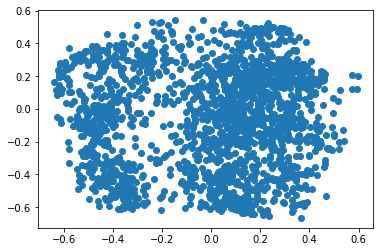

In [ ]:
plt.scatter(xy[:,0],xy[:,1])

In [ ]:
xy[:,0].shape

(1797,)

In [ ]:
xy[:,0].shape

(1797,)